# Classification (분류)

분류 알고리즘

- 베이즈 통계와 생성 모델에 기반한 나이브 베이즈(Naive Bayes)
- 독립변수와 종속변수의 선형 관계성에 기반한 로지스틱 회귀(Logistic Regression)
- 데이터 균일도에 따른 규칙 기반의 결정 트리(Decision Tree)
- 개별 클래스 간의 최대 분류 마진을 효과적으로 찾아주는 서포트 벡터 머신 (Support Vector Machine)
- 근접 거리를 기준으로 하는 최소 근접 알고리즘 (Nearest Neighbor)
- 심층 연결 기반의 신경망 (Neural Network)
- 머신러닝 알고리즘을 결합한 앙상블 (Ensemble) -> ex) 결정트리의 랜덤포레스트 

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from sklearn.tree import export_graphviz
from IPython.core.display import Image
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display # 줄바꿈

## Decision Tree

데이터에 있는 규칙을 자동으로 찾아내 Tree 기반의 분류 규칙을 만든다. (if/eles)

장점 : 정보의 균일도만 신경쓰면 되므로, 대부분 스케일링과 정규화 같은 전처리를 하지 않음. (영향이 적음)
단점 : 깊어질수록 과적합


### 결정트리의 구조  

Decision Node : 규칙 조건
Leaf Node : 결정된 클래스 값(결정된 분류값) 
Sub Tree : 새로운 규칙 조건마다 생성. 데이터 세트에 피처가 있고 피처가 결합해 규칙 조건을 만들 때마다 규칙 노드가 만들어진다. (많은 규칙 -> 과적합 위험 -> 트리의 깊이(depth)가 깊어질 수록 결정 트리의 예측 성능이 저하될 가능성이 높다) 

- 어떻게 트리를 분할할 것인가, 최대한 균일한(똑같은) 데이터 세트를 구성할 수 있도록 분할하는 것이 필요함.
- ex ) 초록공 / 빨강 + 파랑공
- 정보의 균일도를 측정하는 대표적인 방법은 엔트로피를 이용한 정보 이득(Information Gain)지수와 지니 계수가 있다.
- 엔트로피 : 주어진 데이터 집합의 혼잡도. 높을수록 다른 값끼리 모여있는것. 낮을수록 같은 값. 
- 정보이득지수 : 1 - 엔트로피 지수 (결정트리는 정보이득지수가 높은 속성을 기준으로 분할)
- 지니계수 : 낮을수록 데이터 균일도가 높음. (지니계수가 낮은 속성을 기준으로 분할)


정보의 균일도↑ 엔트로피↓ 정보이득지수↑ 지니계수↓

##### 데이터 정보

https://www.kaggle.com/datasets/uciml/glass

This is a Glass Identification Data Set from UCI. It contains 10 attributes including id. The response is glass type(discrete 7 values)

Type of glass: (class attribute)

- 1 building_windows_float_processed 건물 창문 부유 처리
- 2 building_windows_non_float_processed
- 3 vehicle_windows_float_processed
- 4 vehicle_windows_non_float_processed (none in this database)
- 5 containers 용기
- 6 tableware
- 7 headlamps 헤드램프

columns

- Id number: 1 to 214 (removed from CSV file)
- RI: refractive index
- Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
- Mg: Magnesium
- Al: Aluminum
- Si: Silicon
- K: Potassium
- Ca: Calcium
- Ba: Barium
- Fe: Iron

In [2]:
# 데이터 불러오기
df = pd.read_csv("datasets/glass.csv")

# 데이터 샘플 확인
df.head()


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
# 칼럼 정보 확인
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [23]:
df['Type'].value_counts()

Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

-> 결측값 없고, 모든 컬럼이 float64, Type int64로 종류는 6개


In [26]:
# Type 컬럼 문자형 변환

df["Type_str"] = df["Type"].apply(str) # apply() 데이터 프레임의 열에 함수를 적용하고, 그 결과를 새로운 열에 저장하는 데 사용되는 Pandas 함수
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,Type_str
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1,1


In [29]:
df.drop('Type', axis=1, inplace=True)
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_str
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## 의사결정나무 모델용 데이터셋 가공

In [30]:
# 독립변수, 종속변수 분리

컬럼y = "Type_str"
컬럼x = list(df.columns)
컬럼x.remove("Type_str")

df_x = df[컬럼x]
df_y = df[[컬럼y]]


# 학습셋과 테스트셋 분리하여 생성
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.4,random_state=77)

# 확인
print('train',len(x_train))
print('test',len(x_test))


train 128
test 86


학습데이터 128개, 검증데이터 86개 너무 적은데?
-> 그래서 6:4로 나눔  

In [6]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 180 to 95
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      128 non-null    float64
 1   Na      128 non-null    float64
 2   Mg      128 non-null    float64
 3   Al      128 non-null    float64
 4   Si      128 non-null    float64
 5   K       128 non-null    float64
 6   Ca      128 non-null    float64
 7   Ba      128 non-null    float64
 8   Fe      128 non-null    float64
dtypes: float64(9)
memory usage: 10.0 KB


In [31]:
# 잘 쪼개졌나 확인
y_train.value_counts()


Type_str
2           48
1           41
7           15
3           11
5            9
6            4
Name: count, dtype: int64

뭐.. 데이터가 워낙 적으니까 하는 안일한 마음으로 넘어가기

### 의사결정나무 모델 학습

 의사결정나무 모델 학습

모델 생성 및 학습

- DecisionTreeClassifier()

 파라미터 
- min_samples_split : 노드를 분할하기 위한 최소한의 샘플 데이터수, 디폴트 2, 작을수록 노드가 적어져서 과적합 가능성 증가
- min_samples_leaf : 말단 노드가 되기 위한 최소한의 샘플 데이터 수. 비대칭적 데이터는 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요
- max_features : 디폴트 none(전체 피처), 최대 피처 개수, int형이면 대상 피처의 개수, float는 대상 피처의 퍼센트
- max_depth : 트리의 최대 깊이, None이면 계속 분할함. 
- max_leaf_nodes : 말단 노드의 최대 개수
- criterion :  불순도(impurity)를 측정하는 기준  "gini" / "entropy" 
- splitter: 노드 분할 방법 선택 기본값은 best, 최선의 분할 지점을 찾음
- presort: 데이터 정렬 여부로 대규모 데이터에는 부적합
- ccp_alpha: 가지치기를 제어. 값이 클수록 더 많은 가지치기가 수행
- class_weight: 클래스 가중치를 지정. 불균형한 클래스 분포를 조정하기 위해 사용

In [8]:
# 랜덤만 맞춰주고 모두 디폴트로 수행 
dt_model = DecisionTreeClassifier(random_state=77) 
dt_model.fit(x_train,y_train) 

# 검증 예측
y_pred = dt_model.predict(x_test)

# 정확도 계산
print('분류 정확도:',round(accuracy_score(y_test,y_pred),3))

# DecisionTreeClassifier 의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:')
display(dt_model.get_params())

분류 정확도: 0.802
DecisionTreeClassifier 기본 하이퍼 파라미터:


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 77,
 'splitter': 'best'}

### 트리 깊이(depth)가 예측 정확도에 주는 영향 확인

In [33]:
# 그리드 서치(grid search) 방법을 사용하여 모델의 최적 하이퍼파라미터 조합 찾음
from sklearn.model_selection import GridSearchCV 

params = {
    'max_depth' : [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
    'min_samples_split' : [2]
}

grid_cv = GridSearchCV(dt_model,param_grid=params,scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(x_train,y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터',grid_cv.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


C:\Users\LG\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV 최고 평균 정확도 수치 : 0.6785
GridSearchCV 최적 하이퍼 파라미터 {'max_depth': 3, 'min_samples_split': 2}


In [11]:
# 반복문으로 확인
max_depth = list(range(1,30))

# 정확도 저장
accuracy_temp = []
same_cnt = 0
accuracy_dict = {}

# max_depth를 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 확인
for i in range(len(max_depth)) :
    dt_model = DecisionTreeClassifier(max_depth=max_depth[i],min_samples_split=2,random_state=77)
    dt_model.fit(x_train,y_train)
    y_pred = dt_model.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    accuracy_dict[max_depth[i]] = accuracy

    # 정확도가 변하지 않으면 break 
    if accuracy in accuracy_temp:
        same_cnt += 1
        if same_cnt > 4 : # 정확도가 3번 이상 같아지면 중단
            break
    else :
        accuracy_temp.append(accuracy)
        
    # max_depth에 따른 정확도 출력
    print('max_depth =',max_depth[i] ,'분류 정확도:',accuracy)


# 정확도가 가장 높은 것들 중에서 max_depth가 가장 낮은걸 찾기 
best_max_depth, best_accuracy = (sorted(accuracy_dict.items(), key = lambda item: item[1],reverse=True))[0]
best_max_depth, best_accuracy



max_depth = 1 분류 정확도: 0.46511627906976744
max_depth = 2 분류 정확도: 0.5930232558139535


max_depth = 3 분류 정확도: 0.686046511627907
max_depth = 4 분류 정확도: 0.7325581395348837
max_depth = 5 분류 정확도: 0.6976744186046512
max_depth = 6 분류 정확도: 0.7325581395348837
max_depth = 7 분류 정확도: 0.7325581395348837
max_depth = 8 분류 정확도: 0.8023255813953488
max_depth = 9 분류 정확도: 0.8023255813953488
max_depth = 10 분류 정확도: 0.8023255813953488


(8, 0.8023255813953488)

In [12]:
# 가장 최적화 된 하이퍼파라미터로 출력 
dt_model = DecisionTreeClassifier(random_state=77, max_depth=best_max_depth, min_samples_split=2) 
dt_model.fit(x_train,y_train) 

# 검증 예측
y_pred = dt_model.predict(x_test)

# 정확도 계산
print('분류 정확도:',round(accuracy_score(y_test,y_pred),3))

분류 정확도: 0.802


#### 의사결정나무 변수 중요도 확인

In [32]:
# 독립변수 중요도 확인 (feature_importances_ 함수 : 각 독립변수가 분류 예측에 얼마나 중요한지 수치로 표현)
dt_model.feature_importances_

tree_imp = pd.DataFrame({'feature':x_train.columns,
                        'importance':dt_model.feature_importances_,
                        }).sort_values(by='importance', ascending=False,ignore_index=True)

tree_imp

,feature,importance
0,Mg,0.181166
1,Ba,0.166823
2,Ca,0.152742
3,Al,0.151027
4,RI,0.133164
5,Si,0.061338
6,Na,0.056832
7,K,0.054085
8,Fe,0.042822


Type에 영향을 끼치는 순서대로 정렬함. Mg ~ Fe 순으로 영향을 끼친다.

### 의사결정나무 시각화

In [34]:
# https://graphviz.org/download/#windows
# 다운로드 받아라 

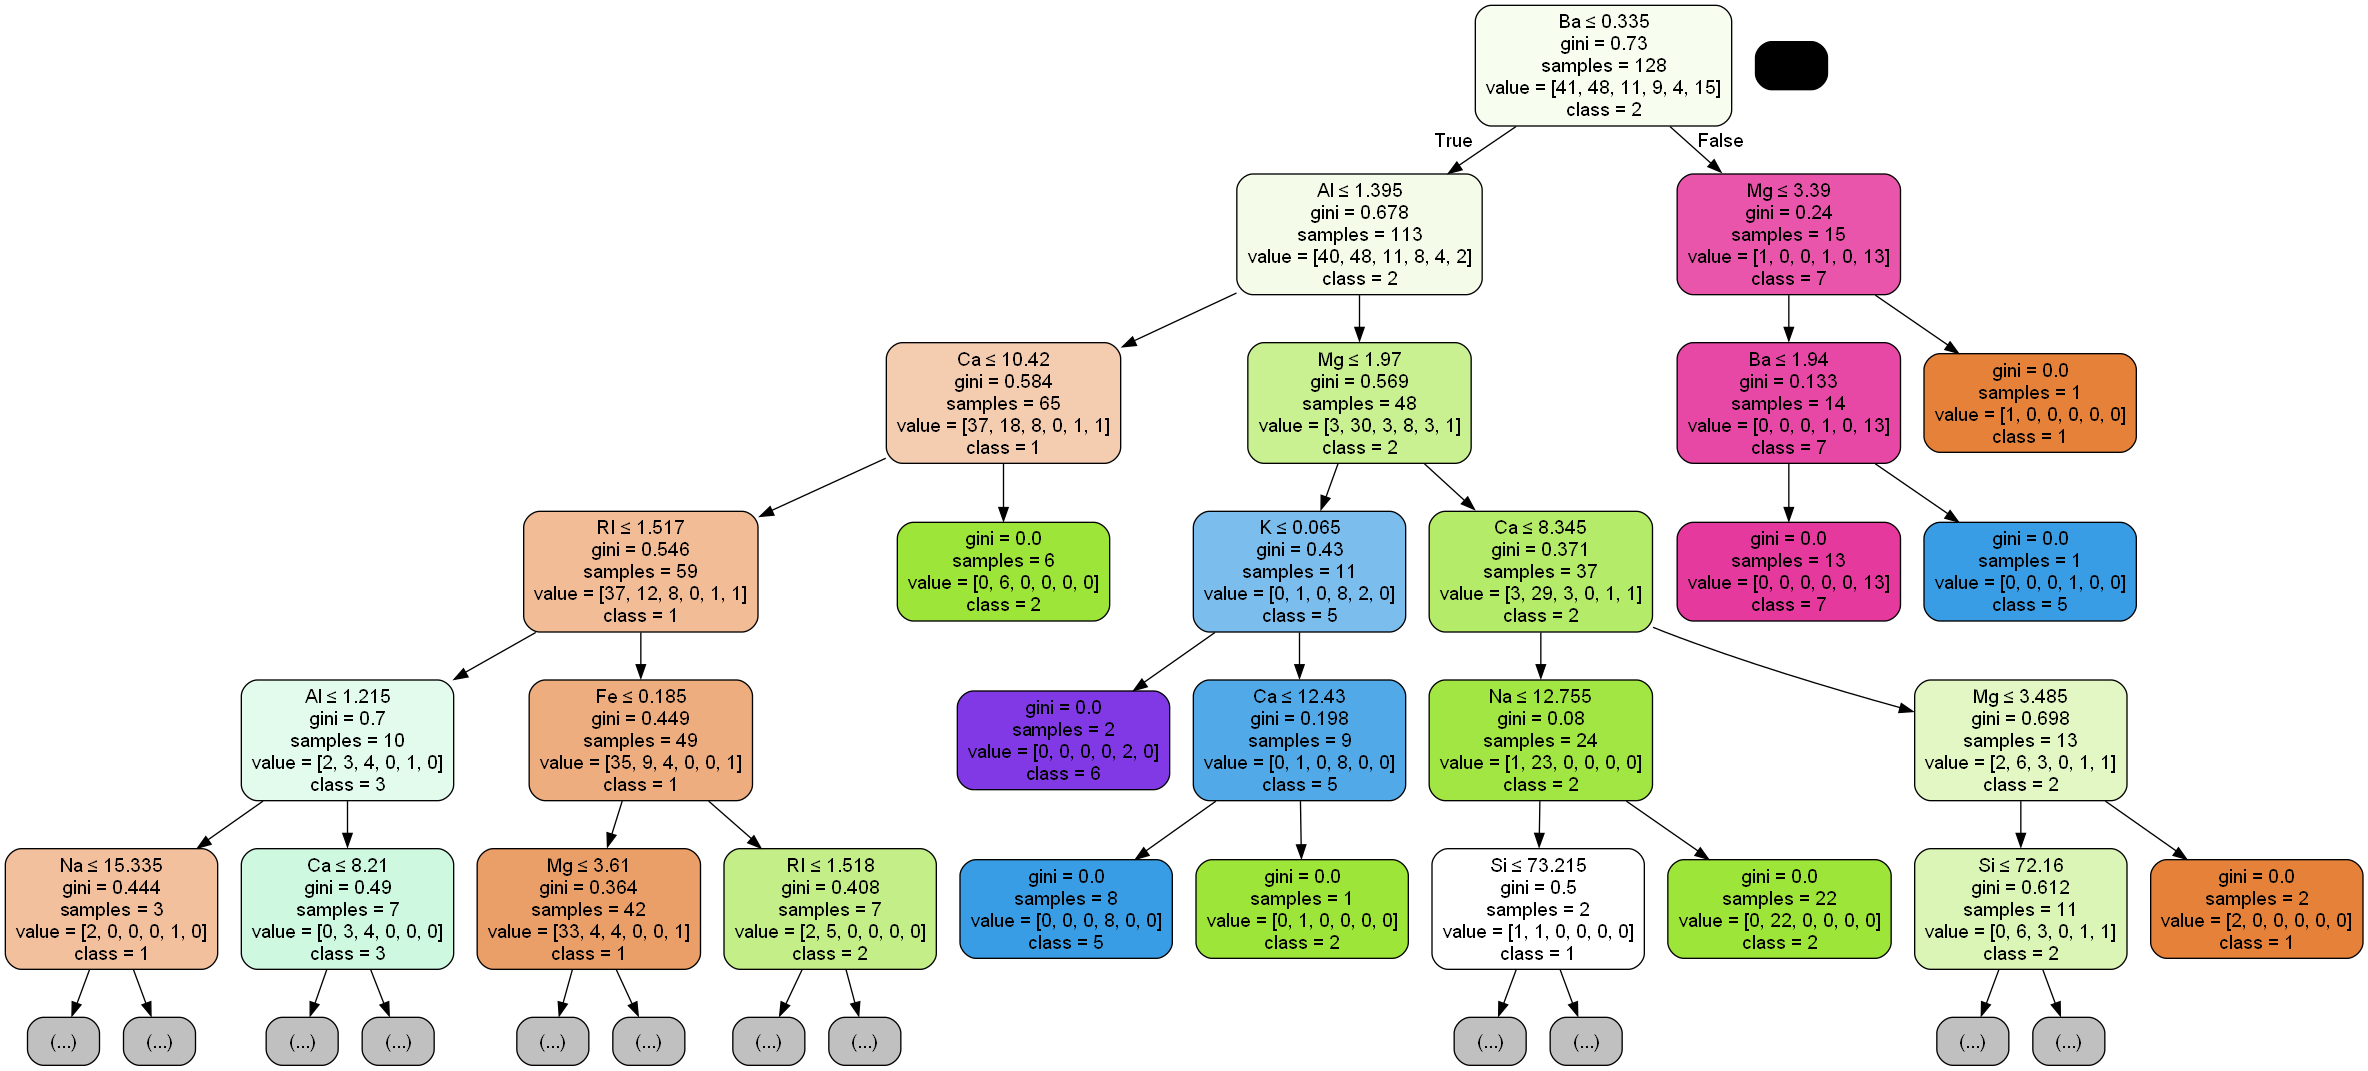

In [14]:
# 의사결정나무 시각화

# out_file=None : 결과를 파일로 저장하지 않겠다.
# filled=True : 상자 채우기
# rounded=True : 상자모서리 둥그렇게 만들기
# special_characters=True : 상자안에 내용 넣기

# 시각화 세부 옵션 설정
dot_data = export_graphviz(dt_model, out_file=None,max_depth=5,
                           feature_names=x_train.columns,
                           class_names=dt_model.classes_,
                           filled=True, rounded=True,
                           special_characters=True)

# # 시각화
dot_data
graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())



- 자식 노드를 만들기 위한 규칙 조건 (없으면 리프 노드)
- gini : 다음 value=[] 로 주어진 데이터 분포에서의 지니계수
- samples : 현 규칙에 해당하는 데이터 건수
- values= [] 클래스 값 기반의 데이터 건수 

## 랜덤포레스트 모델 생성

지니 : 노드 내에 서로 다른 클래스의 데이터가 얼마나 섞여 있는지를 측정

엔트로피 : 노드 내의 데이터 분포의 무질서도를 측정

In [44]:
# criterion='gini'옵션으로 지니 계수로 학습을 시킴 
rnf_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=77,
                                   bootstrap=True, class_weight=None, criterion='gini',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, min_samples_leaf=1, 
                                   min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                   n_jobs=None, oob_score=False,  verbose=0,
                                   warm_start=False,max_features='sqrt')  

rnf_model.fit(x_train,y_train)

y_pred = rnf_model.predict(x_test)
print('정확도: ',(round(accuracy_score(y_test,y_pred),4)*100),'%')

C:\Users\LG\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


정확도:  79.07 %


In [48]:
# 랜덤포레스트 모델 성능 리포트 출력

print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           1       0.79      0.90      0.84        29
           2       0.73      0.79      0.76        28
           3       1.00      0.50      0.67         6
           5       0.50      0.50      0.50         4
           6       1.00      0.60      0.75         5
           7       1.00      0.93      0.96        14

    accuracy                           0.80        86
   macro avg       0.84      0.70      0.75        86
weighted avg       0.82      0.80      0.80        86



- precision(정밀도) : 1로 예측한 관측치 중 실제 1
- recall (재현율) = 민감도 : 실제 1 중에서 모델이 1로 예측 (50%이상이면 선방) -> 정밀도와 민감도는 서로 반대 관계
- f1-score : 정밀도와 민감도가 한쪽으로 치우치치 않을 때 상대적으로 높음 
- support : 각 클래스에 대한 실제 샘플 수

- Accuracy : 모델이 전체 샘플 중에서 올바르게 분류한 샘플의 비율
- Macro Avg : 모든 클래스에 대한 평균 값
- Weighted Avg: 가중치를 적용하여 평균 계산

In [45]:
# criterion='entropy'옵션으로 지니 계수로 학습을 시킴 
rnf_model = RandomForestClassifier(n_estimators=100,max_depth=8, random_state=77,
                                   bootstrap=True, class_weight=None, criterion='entropy',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, min_samples_leaf=1, 
                                   min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                   n_jobs=None, oob_score=False,  verbose=0,
                                   warm_start=False,max_features='sqrt') 
rnf_model.fit(x_train,y_train)

y_pred = rnf_model.predict(x_test)
print('정확도: ',(round(accuracy_score(y_test,y_pred),4)*100),'%')

C:\Users\LG\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


정확도:  80.23 %


랜덤포레스트 criterion='entropy', max_depth=8, min_samples_split=2 일 때 최적

In [46]:
# 랜덤포레스트 모델 성능 리포트 출력

print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           1       0.79      0.90      0.84        29
           2       0.73      0.79      0.76        28
           3       1.00      0.50      0.67         6
           5       0.50      0.50      0.50         4
           6       1.00      0.60      0.75         5
           7       1.00      0.93      0.96        14

    accuracy                           0.80        86
   macro avg       0.84      0.70      0.75        86
weighted avg       0.82      0.80      0.80        86



### 랜덤포레스트 변수 중요도 확인

In [47]:
# 랜덤포레스트 변수 중요도 확인
feature_imp = pd.Series(rnf_model.feature_importances_,
                        index=x_train.columns).sort_values(ascending=False)
feature_imp[:20]

Mg    0.196021
Al    0.165116
Ca    0.123046
RI    0.122743
Na    0.114137
K     0.103884
Ba    0.084463
Si    0.067615
Fe    0.022973
dtype: float64

높은 순서대로 중요해

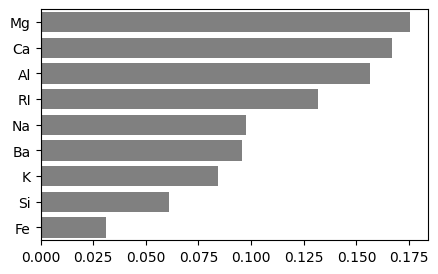

In [18]:
# 랜덤포레스트 변수 중요도 시각화

plt.figure(figsize=(5,3))
sns.barplot(x=feature_imp,y=feature_imp.index,color='gray')
plt.show()
plt.close()

## 보충 - 결정트리 과적합

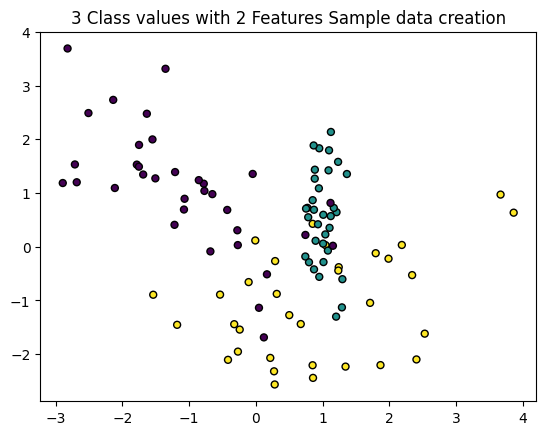

In [19]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("3 Class values with 2 Features Sample data creation")

# 2차원 시각화를 위해서 피처 2, 클래스 3가지 유형의 분류 샘플 데이터 생성
x_features, y_lables =  make_classification(n_features=2, n_redundant=0,n_informative=2,
                                            n_classes=3,n_clusters_per_class=1,
                                            random_state=0)

# 그래프 형태로 2개의 피처로 2차원 좌표 시각화 , 각 클래스 값은 다른 색깔로 표시됨.
plt.scatter(x_features[:,0],x_features[:,1],marker='o',c=y_lables,s=25,edgecolors='k')

In [20]:
def visualize_boundary(model, X, y):
    # X와 y를 사용하여 샘플 데이터를 산점도로 그립니다.
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow', marker='o', s=25)

    # 결정 경계를 그립니다.
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # 모델의 예측 결과로 결정 경계를 그립니다.
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # 등고선 그래프로 결정 경계를 시각화합니다.
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='rainbow')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary Visualization')
    plt.show()


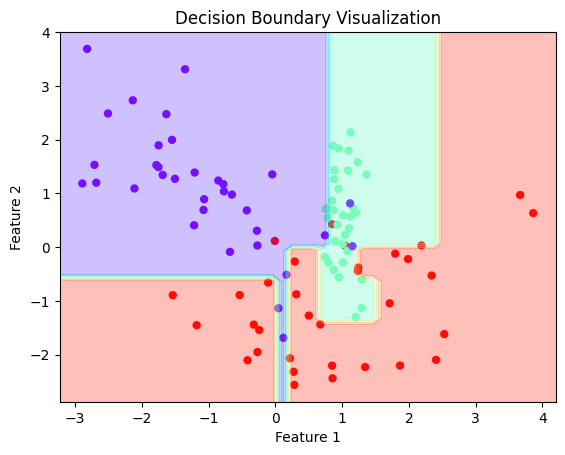

In [21]:
from sklearn.tree import DecisionTreeClassifier

# 특정한 트리 생성 제약없는 결정 트리의 학습과 결정 경계 시각화
dt_clf = DecisionTreeClassifier(random_state=77).fit(x_features, y_lables)
visualize_boundary(dt_clf,x_features, y_lables )

일부 이상치 데이터까지 분류하기 위해 분할이 자주 일어나서 결정 기준 경계가 매우 많아졌다. 결정트리의 기본 하이퍼 파라미터 설정은 리프 노드 안에 데이터가 모두 균일하거나 하나만 존재해야 하는 엄격한 분할 기준으로 인해 결정 기준 경계가 많아지고 복잡해졌다. 이러면 예측 정확도가 떨어지게 된다. 

-> min_samples_leaf = 6 을 설정하여 6개 이하의 데이터는 리프 노드를 생성할 수 있도록 변경

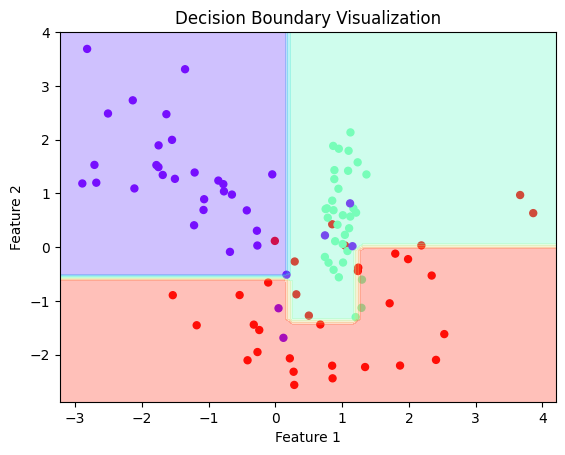

In [22]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=6,random_state=77).fit(x_features, y_lables)
visualize_boundary(dt_clf,x_features, y_lables )

-> 이상차에 크게 반응하지 않으면서 일반화된 분류 규칙에 따라 분류됨.